In [1]:
import pandas as pd
import numpy as np
import pickle
import tcrdist as td
from tcrdist import tcr_distances
from tcrdist import mappers
from tcrdist import objects
from tcrdist.repertoire import TCRrep

### Examine the Comparability of the Original tcr-dist Distance Metric and the tcrdist2 Legacy Metric

The `tcrdist_metric_align_cdr3s_false` function is not used here, but is included in case on were to want to testing the consequence of setting params.align_cdr3s to True
and compute_pairwise_all metric arg is set to 'custom'. In that case we se that the result produced by tcrdist2 will differ from the original tcr-dist results. This implies that align_cdr3s was set to FALSE in the legacy implementation.

In [2]:
def tcrdist_metric_align_cdr3s_false(s1,s2, **kwargs):
    params = td.objects.DistanceParams()
    params.align_cdr3s = False
    dist = tcr_distances.weighted_cdr3_distance(s1, s2, params)
    return(int(dist))

Here we run the legacy configuration in tcrdist2 on all mouse sequences. Unfortunately the clone names are not the same in our procedure so the results will have to be compared based on a join on input features.

In [3]:
pd_df = pd.read_csv("vdjDB_PMID28636592.tsv", sep = "\t")       # 1
t_df = td.mappers.vdjdb_to_tcrdist2(pd_df = pd_df)              # 2
t_df.organism.value_counts                                      # 3
index_mus = t_df.organism == "MusMusculus"                      # 4
#index_mus[:275] = False
#index_mus[287:] = False
t_df_mus = t_df.loc[index_mus,:].copy()                          # 5
tr2 = TCRrep(cell_df = t_df_mus, organism = "mouse")             # 6
tr2.infer_cdrs_from_v_gene(chain = 'alpha', imgt_aligned = True) # <------- # 7
tr2.infer_cdrs_from_v_gene(chain = 'beta',  imgt_aligned = True) # <------- # 8
tr2.index_cols =['epitope',                                      # 9 
                'subject',
                'cdr3_a_aa',
                'cdr1_a_aa',
                'cdr2_a_aa',
                'pmhc_a_aa',
                'cdr3_b_aa',
                'cdr1_b_aa',
                'cdr2_b_aa',
                'pmhc_b_aa',
                'v_a_gene',
                'v_b_gene']
tr2.deduplicate()                                                # 10
tr2.compute_pairwise_all(chain = "alpha",                        # <------- 11
                         metric = 'custom',
                         compute_specific_region = 'cdr3_a_aa',
                         user_function = tcrdist_metric_align_cdr3s_false,
                         processes = 6)
tr2.compute_pairwise_all(chain = "alpha",                        # 11
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr1_a_aa',
                         processes = 6)
tr2.compute_pairwise_all(chain = "alpha",                        # 11
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr2_a_aa',
                         processes = 6)
tr2.compute_pairwise_all(chain = "alpha",                        # 11
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'pmhc_a_aa',
                         processes = 6)

tr2.compute_pairwise_all(chain = "beta",                         # 12 
                         metric = "custom",
                         user_function = tcrdist_metric_align_cdr3s_false,
                         compute_specific_region = 'cdr3_b_aa',
                         processes = 6)
tr2.compute_pairwise_all(chain = "beta",                         # 12
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr1_b_aa',
                         processes = 6)
tr2.compute_pairwise_all(chain = "beta",                         # 12
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr2_b_aa',
                         processes = 6)
tr2.compute_pairwise_all(chain = "beta",                         # 12
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'pmhc_b_aa',
                         processes = 6)

tr2.compute_paired_tcrdist()

/Users/kmayerbl/PycharmProjects/tcrdist2/tcrdist2to3/tcrdist/repertoire.py:149: UserWarning: nan gene was not recognized in reference db no cdr seq could be inferred
  warnings.warn("{} gene was not recognized in reference db no cdr seq could be inferred".format(gene))


{'paired_tcrdist': array([[  0., 253., 253., ..., 279., 256., 237.],
        [253.,   0., 156., ..., 253., 202., 150.],
        [253., 156.,   0., ..., 189., 207., 195.],
        ...,
        [279., 253., 189., ...,   0., 167., 163.],
        [256., 202., 207., ..., 167.,   0.,  82.],
        [237., 150., 195., ..., 163.,  82.,   0.]]),
 'paired_tcrdist_weights': {'cdr1_a_aa_pw': 1,
  'cdr2_a_aa_pw': 1,
  'cdr3_a_aa_pw': 1,
  'pmhc_a_aa_pw': 1,
  'cdr1_b_aa_pw': 1,
  'cdr2_b_aa_pw': 1,
  'cdr3_b_aa_pw': 1,
  'pmhc_b_aa_pw': 1}}

#### Comparison
legacy results were obtained via: 

```bash
python compute_distances.py --clones_file  mouse_pairseqs_v1_parsed_seqs_probs_mq20_clones.tsv --organism mouse

```

`ref_clones` contains the input and information about input seqs

`ref_clones_info` is subset of `ref_clones` containing columns with the relevant features

`tr1_info` is input to the tcrdist2 containing columns wiht relevant input features

We merge `ref_clones_info` and `tr1_info` via a left join to produce a linkage between clone_id in the old dataset and tcrdist2_index in the new dataset that will correspond to `new_distances` --  the distances yielded by tcrdist2



In [4]:
ref_clones = pd.read_csv("mouse_pairseqs_v1_parsed_seqs_probs_mq20_clones.tsv", sep = "\t")

Open a trdist

In [5]:
#tr1 = pickle.load(open("tr1_2.pickle", 'rb'))
tr1 = tr2
new_distances = tr1.paired_tcrdist.copy()

Combine Data That Has the Same Input

In [240]:
tr1_info = tr1.clone_df[['subject', 'epitope','cdr3_a_aa', 'cdr3_b_aa', 'v_a_gene', 'v_b_gene']].copy()
tr1_info['tcrdist2_index'] = tr1_info.index
ref_clones_info = ref_clones[['clone_id', 'subject','epitope', 'cdr3a', 'cdr3b','va_rep', 'vb_rep','va_genes', 'vb_genes']].copy()
merged_info = pd.merge(left = ref_clones_info, 
                       right = tr1_info, 
                       how = "left", 
                       left_on = ['subject','epitope', 'cdr3a', 'cdr3b','va_rep', 'vb_rep'], 
                       right_on = ['subject', 'epitope','cdr3_a_aa', 'cdr3_b_aa', 'v_a_gene', 'v_b_gene'])
ind = merged_info.tcrdist2_index.isna() == False
merged_info.loc[ind,:][['clone_id','tcrdist2_index']].head()

,clone_id,tcrdist2_index
8,mouse_tcr0253.clone,1151.0
9,mouse_tcr0102.clone,1149.0
13,mouse_tcr0369.clone,1165.0
15,mouse_tcr0240.clone,1167.0
17,mouse_tcr0143.clone,1168.0


Suppose we look at this comparison, will all the distances be the same. The answer is no, because the legacy method accounts or multiple possible v-genes and selects the minimum distance.

0.854149490237085


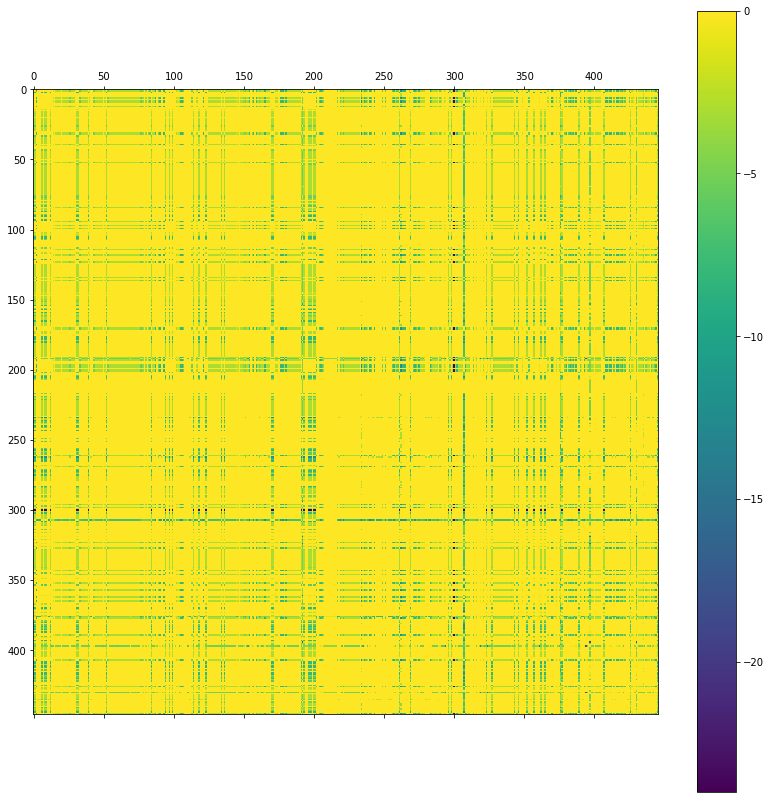

In [259]:
# mi - merged info where a tcrdist2_index value is present (i.e. tcrdist2_index.isna() == False)
mi = merged_info.loc[ind,:].copy()
# clones is a list of mouse_tcr0253.clone, mouse_tcr0102.clone	
clones = mi['clone_id']
# load reference distances from legacy program
ref_distances = pd.read_csv("mouse_pairseqs_v1_parsed_seqs_probs_mq20_clones_AB.dist", sep = " ", header = None)
# use the first colums (mouse_tcr0253.clone, mouse_tcr0102.clone, ...) as an index 
ref_distances.index = ref_distances.iloc[:,0]
# reset the colums names to be clone and then (mouse_tcr0253.clone, mouse_tcr0102.clone, ...)
ref_distances.columns = ["clone"] + ref_distances.index.to_list()
# Now we need the tcrdist2 index positions
tcrdist_index = mi['tcrdist2_index']
# Use these to get the correct rows and columns from the PW matrix
tcrdist_distances = pd.DataFrame(tr1.paired_tcrdist).loc[tcrdist_index, tcrdist_index]
# assert that we have matching sized matrices
assert(tcrdist_distances.shape == ref_distances.loc[clones,clones].shape)
# r_mat will be the reference_matrix, t_mat the tcrdist2 matrix
r_mat = ref_distances.loc[clones,clones].values
t_mat = pd.DataFrame(tr1.paired_tcrdist).loc[tcrdist_index, tcrdist_index].values
# print the % of cells in agreement
print(np.sum(r_mat == t_mat) / np.size(r_mat))
# make a matrix of differences
method_diff = r_mat - t_mat
# make a boolean matrix of agreement
ag = r_mat == t_mat
# Plot the differences
import matplotlib
import matplotlib.pyplot as plt
plt.matshow(method_diff)
plt.colorbar()

We do the same as above but we limit the comparison to only thos seqeuences that had a single Va and Vb gene in the input see the lines wiht `#<----------`

1.0


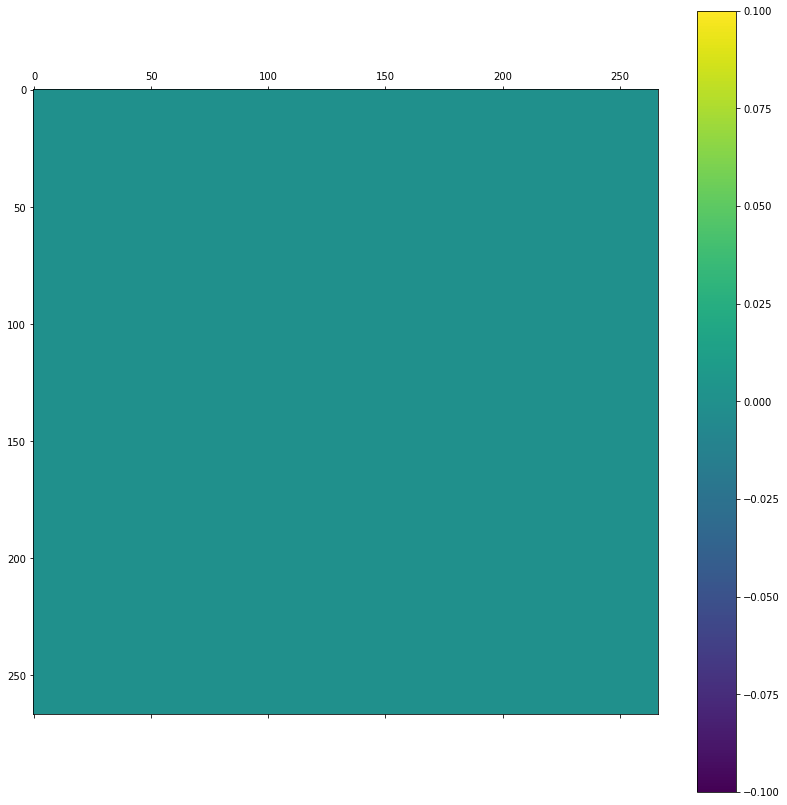

In [263]:
# I NEED TO LOOK ONLY AT THOSE WITH A SINGLE Va and Vb prediction
# mi - merged info where a tcrdist2_index value is present (i.e. tcrdist2_index.isna() == False)
mi = merged_info.loc[ind,:].copy()

# I NEED TO LOOK ONLY AT THOSE WITH A SINGLE Va and Vb prediction
mi = merged_info.loc[ind,:].copy()
ind_va = mi.va_genes.str.find(";") == -1     #<---------- only single v_a genes
ind_vb = mi.vb_genes.str.find(";") == -1     #<---------- only single v_b gene
clones = mi.loc[ind_va&ind_vb,:]['clone_id'] #<---------- clones defined
# clones is a list of mouse_tcr0253.clone, mouse_tcr0102.clone	

# load reference distances from legacy program
ref_distances = pd.read_csv("mouse_pairseqs_v1_parsed_seqs_probs_mq20_clones_AB.dist", sep = " ", header = None)
# use the first colums (mouse_tcr0253.clone, mouse_tcr0102.clone, ...) as an index 
ref_distances.index = ref_distances.iloc[:,0]
# reset the colums names to be clone and then (mouse_tcr0253.clone, mouse_tcr0102.clone, ...)
ref_distances.columns = ["clone"] + ref_distances.index.to_list()

# Now we need the tcrdist2 index positions
tcrdist_index = mi.loc[ind_va&ind_vb,:]['tcrdist2_index'] # <----------- we use ind_va, ind_vb here

# Use these to get the correct rows and columns from the PW matrix
tcrdist_distances = pd.DataFrame(tr1.paired_tcrdist).loc[tcrdist_index, tcrdist_index]
# assert that we have matching sized matrices
assert(tcrdist_distances.shape == ref_distances.loc[clones,clones].shape)
# r_mat will be the reference_matrix, t_mat the tcrdist2 matrix
r_mat = ref_distances.loc[clones,clones].values
t_mat = pd.DataFrame(tr1.paired_tcrdist).loc[tcrdist_index, tcrdist_index].values
# print the % of cells in agreement
print(np.sum(r_mat == t_mat) / np.size(r_mat))
# make a matrix of differences
method_diff = r_mat - t_mat
# make a boolean matrix of agreement
ag = r_mat == t_mat
# Plot the differences
import matplotlib
import matplotlib.pyplot as plt
plt.matshow(method_diff)
plt.colorbar()

#### Designing the Test 
For a formal test let's create an input `test_df` for tcrdist2 and compare it with the `truth_matrix` composed of the reference values from the legacy implementation. This is now in tcrdist2 tests/test_comparabilit_of_tcrdist.py


In [264]:
mi = merged_info.loc[ind,:].copy()
mi.loc[ind_va&ind_vb,:]
test_df = mi.loc[ind_va&ind_vb,:][['clone_id','subject','epitope','cdr3a','cdr3b', 'cdr3_a_aa','cdr3_b_aa', 'v_a_gene', 'v_b_gene', 'va_rep', 'vb_rep','va_genes', 'vb_genes']].copy()
test_df['count'] = 1
test_df.head()

,clone_id,subject,epitope,cdr3a,cdr3b,cdr3_a_aa,cdr3_b_aa,v_a_gene,v_b_gene,va_rep,vb_rep,va_genes,vb_genes,count
13,mouse_tcr0369.clone,mouse_subject0050,PA,CSASKDTNTGKLTF,CASSIARWDSYEQYF,CSASKDTNTGKLTF,CASSIARWDSYEQYF,TRAV5-1*01,TRBV19*01,TRAV5-1*01,TRBV19*01,TRAV5-1*01,TRBV19*01,1
25,mouse_tcr0329.clone,mouse_subject0050,PA,CILVGGSNYKLTF,CASSSGREVFF,CILVGGSNYKLTF,CASSSGREVFF,TRAV21/DV12*01,TRBV29*01,TRAV21/DV12*01,TRBV29*01,TRAV21/DV12*02,TRBV29*01,1
28,mouse_tcr0020.clone,mouse_subject0050,PA,CILRVGATGGNNKLTF,CASSLDRGEVFF,CILRVGATGGNNKLTF,CASSLDRGEVFF,TRAV21/DV12*01,TRBV29*01,TRAV21/DV12*01,TRBV29*01,TRAV21/DV12*02,TRBV29*01,1
39,mouse_tcr0832.clone,mouse_subject0064,m139,CAASENYNQGKLIF,CASSWDRNTGQLYF,CAASENYNQGKLIF,CASSWDRNTGQLYF,TRAV7-4*01,TRBV26*01,TRAV7-4*01,TRBV26*01,TRAV7-4*01,TRBV26*01,1
55,mouse_tcr1720.clone,mouse_subject0073,M38,CAVSSYGSSGNKLIF,CTCSAGTGGFNYAEQFF,CAVSSYGSSGNKLIF,CTCSAGTGGFNYAEQFF,TRAV9N-3*01,TRBV1*01,TRAV9N-3*01,TRBV1*01,TRAV9N-3*01,TRBV1*01,1


In [266]:
clones = mi.loc[ind_va&ind_vb,:]['clone_id']
truth_matrix = ref_distances.loc[clones,clones].values
truth_matrix

array([[  0., 286., 307., ..., 296., 279., 207.],
       [286.,   0., 132., ..., 300., 264., 290.],
       [307., 132.,   0., ..., 333., 288., 299.],
       ...,
       [296., 300., 333., ...,   0., 275., 287.],
       [279., 264., 288., ..., 275.,   0., 251.],
       [207., 290., 299., ..., 287., 251.,   0.]])

In [267]:
pb1 = TCRrep(cell_df = test_df, organism = "mouse")             # 6
pb1.infer_cdrs_from_v_gene(chain = 'alpha', imgt_aligned = True) # <------- # 7
pb1.infer_cdrs_from_v_gene(chain = 'beta',  imgt_aligned = True) # <------- # 8
pb1.index_cols =['epitope',                                      # 9 
                'clone_id',
                 'subject',
                'cdr3_a_aa',
                'cdr1_a_aa',
                'cdr2_a_aa',
                'pmhc_a_aa',
                'cdr3_b_aa',
                'cdr1_b_aa',
                'cdr2_b_aa',
                'pmhc_b_aa',
                'v_a_gene',
                'v_b_gene']
pb1.deduplicate()                                                # 10
pb1.compute_pairwise_all(chain = "alpha",                        # <------- 11
                         metric = 'tcrdist_cdr3',
                         compute_specific_region = 'cdr3_a_aa',
                         #user_function = tcrdist_metric_align_cdr3s_false,
                         processes = 6)
pb1.compute_pairwise_all(chain = "alpha",                        # 11
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr1_a_aa',
                         processes = 6)
pb1.compute_pairwise_all(chain = "alpha",                        # 11
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr2_a_aa',
                         processes = 6)
pb1.compute_pairwise_all(chain = "alpha",                        # 11
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'pmhc_a_aa',
                         processes = 6)

pb1.compute_pairwise_all(chain = "beta",                         # 12 
                         metric = 'tcrdist_cdr3',
                         #user_function = tcrdist_metric_align_cdr3s_false,
                         compute_specific_region = 'cdr3_b_aa',
                         processes = 6)
pb1.compute_pairwise_all(chain = "beta",                         # 12
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr1_b_aa',
                         processes = 6)
pb1.compute_pairwise_all(chain = "beta",                         # 12
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'cdr2_b_aa',
                         processes = 6)
pb1.compute_pairwise_all(chain = "beta",                         # 12
                         metric = "tcrdist_cdr1",
                         compute_specific_region = 'pmhc_b_aa',
                         processes = 6)

pb1.compute_paired_tcrdist()

{'paired_tcrdist': array([[  0., 292., 288., ..., 288., 230., 293.],
        [292.,   0., 275., ..., 291., 251., 220.],
        [288., 275.,   0., ..., 240., 310., 299.],
        ...,
        [288., 291., 240., ...,   0., 263., 266.],
        [230., 251., 310., ..., 263.,   0., 303.],
        [293., 220., 299., ..., 266., 303.,   0.]]),
 'paired_tcrdist_weights': {'cdr1_a_aa_pw': 1,
  'cdr2_a_aa_pw': 1,
  'cdr3_a_aa_pw': 1,
  'pmhc_a_aa_pw': 1,
  'cdr1_b_aa_pw': 1,
  'cdr2_b_aa_pw': 1,
  'cdr3_b_aa_pw': 1,
  'pmhc_b_aa_pw': 1}}

In [269]:
pb1.paired_tcrdist.shape == truth_matrix.shape
pb1.paired_tcrdist == truth_matrix

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False,  True],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False,  True, ..., False, False,  True]])

We need to resort clone_df to make sure it matches the input truth_df order. 
`truth_matrix` is simply the `pb1.paired_tcrdist` resorted and output as a np array

In [270]:
test_order = pb1.clone_df.copy()
test_order['sort_index'] = test_order.index
test_order.index = test_order.clone_id
test_order_sorted = test_order.loc[pb1.cell_df.clone_id,]
sort_index = test_order_sorted['sort_index']
test_matrix = pd.DataFrame(pb1.paired_tcrdist).loc[sort_index, sort_index].values
assert(np.all(test_matrix == truth_matrix))
test_matrix == truth_matrix

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])